# Tensorflow 2.3.1: Generative Adversarial Networks 

This Notebook has been based on three Tensorflow Tutorials convering 3 separate topics. I put them all here together to better understand GANs with color images

* [DCGAN with MNIST](https://www.tensorflow.org/tutorials/generative/dcgan)
* [Artifical Faces with GAN and tf_gan](https://www.tensorflow.org/hub/tutorials/tf_hub_generative_image_module)
* [GAN for Small Color Photographs](https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-a-cifar-10-small-object-photographs-from-scratch/)

PLACEHOLDER FOR INTRODUCTION TEXT

PLACEHOLDER FOR WHERE THE DATA CAME FROM

PLACEHOLDER FOR WHERE I GOT THE DATA

PLACEHOLDER FOR TABLE OF CONTENTS

# Imports

In [1]:
#import the neccessary libraries
import pickle
import matplotlib.pyplot as plt
import PIL
import PIL.Image
import numpy as np
import pandas as pd
import pathlib
import os
import time
from datetime import datetime

import imageio
import glob
from IPython import display

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, LeakyReLU, Reshape, Conv2DTranspose
from tensorflow.keras import layers
from tensorflow.keras import Input

In [2]:
# for optimization of the neural networks
%load_ext tensorboard

In [3]:
tf.__version__

'2.3.1'

Let's add a relative filepath and an absolute filepath:

In [4]:
filepath = 'data/celeba'

In [5]:
data_dir = pathlib.Path(filepath).absolute()

In [6]:
data_dir

PosixPath('/data/capstone/gnn-examples/scratch_gnn_example/data/celeba')

Let's get a filelist:

In [7]:
filelist = [str(i) for i in list(data_dir.glob('*.jpg'))]

In [8]:
filelist[0]

'/data/capstone/gnn-examples/scratch_gnn_example/data/celeba/180560.jpg'

Let's see what kind of pictures we are working with: 

# Exploratory Data Visualization

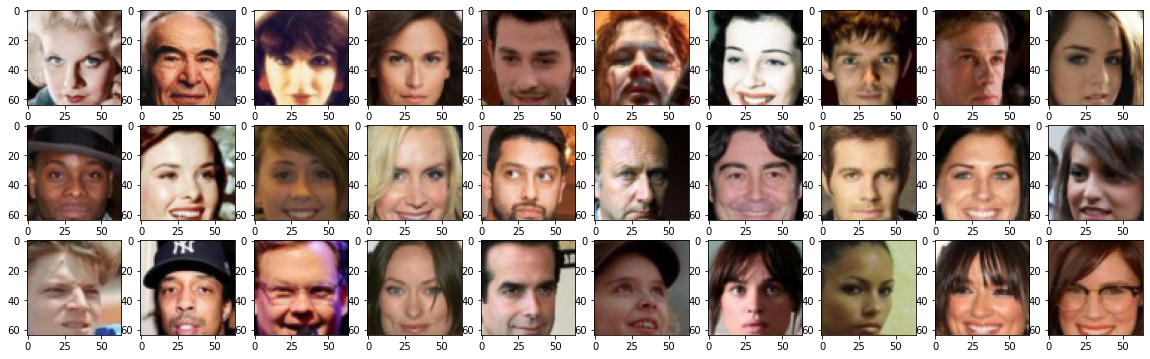

In [9]:
plt.figure(figsize=(20, 6))
for i in range(30):
    plt.subplot(3, 10,i+1)
    plt.imshow(PIL.Image.open(np.random.choice(filelist)))

Another method of showing images using matplotlib:

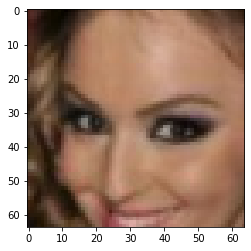

In [10]:
plt.imshow(plt.imread(filelist[0]))

If we are going to load this data into a TF neural network, it needs to be wrapped in a tensorflow data loader:

In [11]:
def decode_img(img_path):
    '''
    Convert a string filepath into a TF tensor
    '''
    img_path = tf.convert_to_tensor(img_path, dtype=tf.string)
    return tf.image.decode_jpeg(tf.io.read_file(img_path))

In [12]:
test = decode_img(filelist[0])

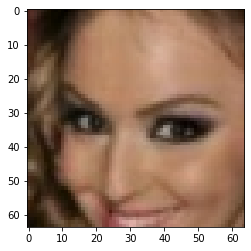

In [13]:
plt.imshow(test)

In [14]:
type(test)

tensorflow.python.framework.ops.EagerTensor

In [15]:
test.shape

TensorShape([64, 64, 3])

Alright our simple image dataloader works! Let's put it into a batcher so we can lazy load 128 at a time

# Dataloading

In [16]:
# So we have a filelist, as well as a function which loads an image as a tensor.
# To make a batching lazy loader, let's consider how many images we want to push to our GAN at each time

In [17]:
# So, each pass we want to process an array that is of size (128, 64, 64, 3) which is of type (BATCH, WIDTH, HEIGHT, CHANNELS)

In [18]:
# Currently we have this kind of input:

In [19]:
test.shape

TensorShape([64, 64, 3])

In [20]:
# Now we need to put 128 of them into a single array

In [21]:
dataset = tf.data.Dataset.from_tensor_slices(filelist)

In [22]:
type(dataset)

tensorflow.python.data.ops.dataset_ops.TensorSliceDataset

In [23]:
def dataloader(filelist, BATCH_SIZE, BUFFER_SIZE):
    """
    Consume a list of filename strings
    
    Convert the strings into a tensorflow compressed dataset
    Batch 128 tensorflow tensor stings together
    
    Returns a tensorflow dataset object 
    
    https://www.tensorflow.org/tutorials/load_data/images#using_tfdata_for_finer_control
    """
    # https://www.tensorflow.org/guide/data_performance#prefetching
    # This is an experimental feature from tensorflow which handles prefetching the data
    # Tensorflow will use a background thread and an internal buffer to prefetch elements from the input dataset
    # ahead of when they are requested
    # number of elements to prefetch shold be => number of batches consumed by a single training step
    AUTOTUNE = tf.data.experimental.AUTOTUNE
    
    dataset = tf.data.Dataset.from_tensor_slices(filelist) # load the filelist into an object that represents the whole dataset
    # tensorflow.python.data.ops.dataset_ops.TensorSliceDataset
    
    # https://stackoverflow.com/questions/46444018/meaning-of-buffer-size-in-dataset-map-dataset-prefetch-and-dataset-shuffle
    # Changing the size of the buffer size here modifies how random the data is. 
    
    def decode_img(img):
        '''
        Local function, load each image and convert into a unsigned 8 integer
        '''
        # convert the compressed string to a 3D uint8 tensor
        return tf.image.decode_jpeg(img, channels=3)
    
    def process_path(file_path):
        # load the raw data from the file as a string
        img = tf.io.read_file(file_path)
        # run nested function to decode image
        img = decode_img(img)
        return img
    
    def configure_for_performance(ds, BATCH_SIZE=BATCH_SIZE):
        '''
        Optimize the data for preformance
        '''
        ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
        ds = ds.map(process_path, num_parallel_calls=tf.data.experimental.AUTOTUNE)
        ds = ds.cache()
        ds = ds.shuffle(buffer_size=BUFFER_SIZE)
        ds = ds.batch(BATCH_SIZE, drop_remainder=True)
        return ds
    
    dataset = configure_for_performance(dataset)
    
    return dataset

https://www.tensorflow.org/guide/gpu

Some fun notes about using tensorflow 2.0

In the past we had to load the data into gpu. however today, tensorflow will transparently run on a single gpu with no code changes, so it is avaiable out of the box

# Discriminator and Generator Neural Networks

Here we've made a 64 x 64 color image generator. It is untrained so it will make no sense. That's okay!

In [24]:
# define the standalone generator model
def make_generator_model(latent_dim):
    model = Sequential()
    # foundation for 4x4 image
    n_nodes = 256 * 4 * 4
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((4, 4, 256)))
    # upsample to 8x8
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 16x16
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 32x32
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 64x64
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # output layer
    model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
    return model

In [25]:
latent_dim = 100 # vector of random numbers from a normal distribution

generator = make_generator_model(latent_dim)

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
converted_output = ((generated_image + 1) / 2) # move values from [-1, 1,] to [0, 1]

In [26]:
converted_output.shape

TensorShape([1, 64, 64, 3])

Text(0.5, 0.98, '3 Channel Generated Imaged with Combined Color Image')

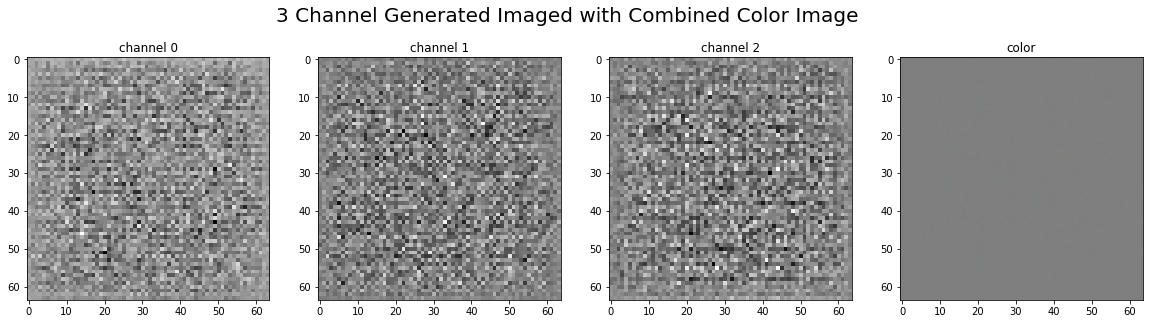

In [27]:
plt.figure(figsize=(20, 5))

for i in range(0,3):
    plt.subplot(1,4,i+1)
    plt.imshow(converted_output[0,:,:,i], cmap='gray')
    plt.title(f'channel {i}')

plt.subplot(1,4,4)
plt.imshow(converted_output[0,:,:,:])
plt.title('color');
plt.suptitle('3 Channel Generated Imaged with Combined Color Image', fontsize=20)

Neat, our generator is able to make 64x64 color images. Right now it sure doesn't mean anything but hey ! 

In [28]:
def make_discriminator():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[64, 64, 3])) 
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [29]:
discriminator = make_discriminator()

In [30]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 64)        4864      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       204928    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 32768)            

In [31]:
decision = discriminator(generated_image)
decision, np.average(decision)

(<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[3.6770496e-05]], dtype=float32)>,
 3.6770496e-05)

So looking at these numbers, we have a set of predictions from our discriminator, our CNN.

It evaluates each channel as a separate image, but we can consider the average of the 3 numbers as the overall prediction

The higher the number the more "real"

The lower the number the more "fake"

The closer to 0, the more unsure our network is 

# Discriminator and Generator Losses

In order for our neural networks to start being adversarial to each other, we are going to need to setup two losses, one for each network respectitely

In [32]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [33]:
# This one will define how well our discriminator does by classifying images, real from fake.

# So our discriminator is just a well trained classification neural network. If we had wanted to, instead of using our own small model we could use
# ImageNet as our discriminator, because it is pretrained and already knows objects.

# It compares the predictions of the discriminator to the ground truth of
# real pictures are 1
# fake pictures are 0

In [34]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [35]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [36]:
# The generator's loss is just a measure of how well it can trick the discriminator

# If fake images are seen as real images = 1
# if fake images are seen as fake images = 0

In [37]:
# Let's set up the two optimizers

In [38]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

## Callbacks

### Checkpoints

In [39]:
# After we have set up all of the definitions, let's also set up a 
# checkpoint system so we can return to a previous epoch or load a new model and contuine training

In [40]:
# https://www.tensorflow.org/guide/checkpoint

In [41]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [42]:
# saved model rootfile
model_dir = './saved_models'

In [43]:
# Restore  and contuine training from a checkpoint

def train_from_checkpoint(dataset):
    latest = tf.train.latest_checkpoint(checkpoint_dir)
    model = create_model()
    model.load_weights(latest)

In [44]:
# Let's set up a training loop so we can execute one instance of the generator making an image and the discrimiator classifying the image as real or fake

In [45]:
# Our hyperparameters

# Training

In [46]:
noise_dim = 100
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim]) 

In [47]:
seed

<tf.Tensor: shape=(16, 100), dtype=float32, numpy=
array([[ 0.39701986,  0.01733718, -0.71063113, ..., -0.95434344,
        -0.37478992,  2.1452281 ],
       [-1.1781865 ,  1.2878681 , -1.4327012 , ...,  0.10374137,
         1.227583  ,  0.21673101],
       [ 0.18322271,  0.7687887 , -0.5472541 , ...,  0.2850586 ,
        -1.7169079 , -0.4990078 ],
       ...,
       [-0.24357346, -0.50399894,  0.320336  , ...,  0.9793828 ,
         0.62059885, -0.29143536],
       [ 0.6118862 ,  1.682311  ,  1.0219748 , ...,  0.6315505 ,
        -0.55271006, -0.77415794],
       [-1.7626245 , -0.04603119,  0.7151763 , ..., -0.2721431 ,
        -0.40185142, -0.24465163]], dtype=float32)>

https://www.tensorflow.org/api_docs/python/tf/GradientTape

Gradient tape records operations for automatic differntiation. This automatically computs the gradient of a computation with respect to the inputs
 
https://en.wikipedia.org/wiki/Automatic_differentiation

Automatic differentiation is a set of techniques to numerically evaluate the deriverate of a function. In the case of the neural networks, we are finding the local minima and maxima of the linear equations with respect to the neural network

We do NOT want to be manually calculating the deriverative of each equation, of each step. so this is a convieneance function provided by tensorflow

the general idea on how Autodifferentiation works is as seen:

# INSERT LATEX OF THE AUTO DIFFERENTIATION

## One Training Step

In [48]:
# https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch

# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".

@tf.function # This is equivalent to doing model.compile()

def train_step(images):
    '''
    This is equivalent to calling model.fit()
    '''
    
    # set up random noise to be input into the GAN
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Because we are calculating two losses, we are going to need two instances of GradientTape
        # GradienTape records the operations conducted 
        
        # Generate a fake image with the noise 
        generated_images = generator(noise, training=True)

        # Input in an image from the passed input dataset
        real_output = discriminator(images, training=True)
        
        # Input in the fake image that was created from the Generator
        fake_output = discriminator(generated_images, training=True)
        
        # Put Callbacks here:
        # Calculate our metrics:
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
        
    # https://builtin.com/data-science/gradient-descent
    # Quick Reminder; a gradient measures how much the output of a function changes if you change the inputs a little bit 
    
    # Using the gradients that we just watched, calculate the gradients of the models
    # tf.GradientTape().gradient() computes the gradient
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    # Now we calculated the gradients, we apply them back to our neural networks: the generator and discriminator
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    # update the metrics
    
    
    return gen_loss, disc_loss

# GAN Output Visualizer

In [49]:
def generate_and_save_images(model, epoch, test_input, previous_epochs=0):
    
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow((predictions[i, :, :, :] + 1) / 2)
        plt.axis('off')
        plt.suptitle(f'Generated Faces at Epoch: {epoch+previous_epochs}', y=1)


    plt.savefig('images/faces_at_epoch_{:04d}.png'.format(epoch+previous_epochs))
    plt.show()

## Training Loop

In [50]:
def train(dataset, epochs, previous_epochs=0):
    # set up tensorflow profiler
    
    # set up our empty data structures
    dict_loss = {'gen-loss': [], 'disc-loss': []}
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch)
            dict_loss.get('gen-loss').append(gen_loss)
            dict_loss.get('disc-loss').append(disc_loss)

        # Produce images for the GIF as we go
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1 + previous_epochs, seed, previous_epochs=0)

        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
            filepath = model_dir+f"generator-model-{epoch+1+previous_epochs}"
            filepath = model_dir+f"/enerator-model-{epoch+1+previous_epochs}"
            save_gen = generator.save_weights(filepath)
            save_disc = discriminator.save_weights(filepath)


        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start) + '\n' 
               + 'Generator Loss: {} | Discriminator Loss: {}'.format(gen_loss, disc_loss))

  # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs+previous_epochs, seed,previous_epochs=0)
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start) + '\n' 
       + 'Generator Loss: {} | Discriminator Loss: {}'.format(gen_loss, disc_loss))
    return dict_loss

In [51]:
len(filelist) // 768

42

In [52]:
512 + 256

768

In [53]:
EPOCHS = 15
PROFILE = False
BATCH_SIZE = 768
BUFFER_SIZE = len(filelist)

In [54]:
dataset = dataloader(filelist, BATCH_SIZE=BATCH_SIZE, BUFFER_SIZE=BUFFER_SIZE)

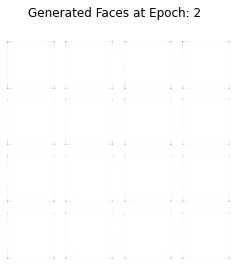

Time for epoch 2 is 47.4025194644928 sec
Generator Loss: 0.7144413590431213 | Discriminator Loss: 0.7239946722984314


KeyboardInterrupt: 

In [55]:
if PROFILE == True:
    from tensorflow.python.profiler import profiler_v2 as profiler

    profiler.warmup()
    profiler.start(logdir='logdir')
 
    history = train(dataset, EPOCHS, previous_epochs=0)

    profiler.stop()
else:
    history = train(dataset, EPOCHS, previous_epochs=0)

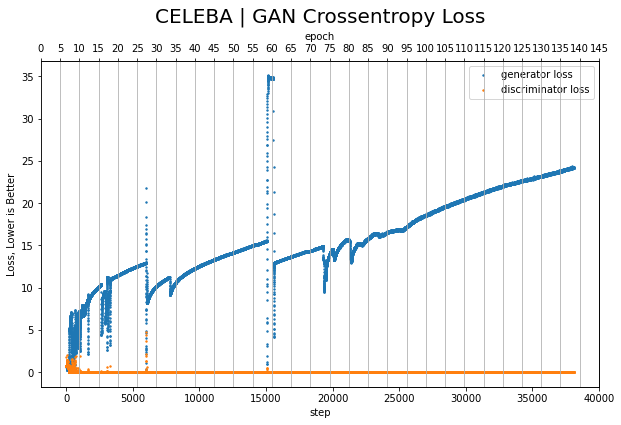

In [56]:
plt.figure(figsize=(10,6))
plt.scatter(x=range(len(history.get('gen-loss'))), y=[float(i) for i in history.get('gen-loss')], label='generator loss', s=2)
plt.scatter(x=range(len(history.get('disc-loss'))), y=[float(i) for i in history.get('disc-loss')], label='discriminator loss', s=2)
plt.title('CELEBA | GAN Crossentropy Loss', fontsize=20, pad=10)
plt.ylabel('Loss, Lower is Better')
plt.legend()
axes1 = plt.gca()
axes2 = axes1.twiny()
axes2.set_xticks(range(0, EPOCHS, 5))
axes1.set_xlabel("step")
axes2.set_xlabel("epoch")
axes2.grid()

In [57]:
# Launch TensorBoard and navigate to the Profile tab to view performance profile
#%tensorboard --logdir logdir

In [63]:
file_name = "history.pkl"

open_file = open(file_name, "wb")
pickle.dump(history, open_file)
open_file.close()

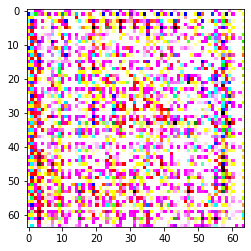

In [70]:
plt.imshow(((generator(seed)+1)/2)[0,:,:,:])

In [57]:
checkpoint.restore(tf.train.latest_checkpoint('./training_checkpoints_trial_2/'))

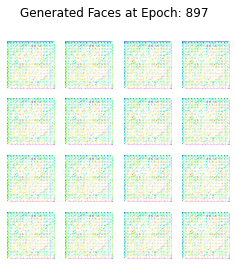

Time for epoch 731 is 48.80074191093445 sec
Generator Loss: 28.37761878967285 | Discriminator Loss: 5.216830656698535e-13


In [ ]:
EPOCHS = 1500
history2 = train(dataset, EPOCHS, previous_epochs=166)

In [ ]:
file_name = "history2.pkl"

open_file = open(file_name, "wb")
pickle.dump(history, open_file)
open_file.close()

In [ ]:
def gif_maker():
    '''
    Hardcoded gif maker for this repo
    '''
    anim_file = 'scratch_gan.gif'

    with imageio.get_writer(anim_file, mode='I') as writer:
        filenames = glob.glob('images/faces*.png')
        filenames = sorted(filenames)
        for filename in filenames:
            image = imageio.imread(filename)
            writer.append_data(image)
        image = imageio.imread(filename)
        writer.append_data(image)
    return anim_file

In [ ]:
anim_file = gif_maker()
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

In [ ]:
#checkpoint.restore(tf.train.latest_checkpoint('./first_60_training_checkpoints'))

In [ ]:
'''
display.clear_output(wait=True)
generate_and_save_images(generator,
                       60,
                       seed,
                        previous_epochs=0)
''';

In [ ]:
#history_2 = train(dataset, 76, previous_epochs=60)